In [1]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# The path of the directories are assigned to varibles 
train_dir = "/kaggle/input/ml-league-cnn-assignment/RealWaste"
test_dir = "/kaggle/input/ml-league-cnn-assignment/Test"  # Test images stored here


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2) 

# Setting up ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,           
    rotation_range=20,        
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    shear_range=0.2,          
    zoom_range=0.2,           
    horizontal_flip=True,     
    fill_mode='nearest',      
    validation_split=0.2      
)


In [4]:
# Training with smaller image size to reduce memory usage
target_size = (400, 400)  

training_dataset = datagen.flow_from_directory(
    directory=train_dir,
    target_size=target_size,  
    batch_size=32,            
    class_mode='categorical', 
    subset='training'         
)

validation_dataset = datagen.flow_from_directory(
    directory=train_dir,       
    target_size=target_size,   
    batch_size=32,             
    class_mode='categorical',  
    subset='validation'        
)

Found 3659 images belonging to 9 classes.
Found 913 images belonging to 9 classes.


In [5]:
# now extracting the test data set
test_datagen = ImageDataGenerator(rescale=1.0/255.0)  

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(400, 400),  
    batch_size=32,           
    class_mode=None,         
    shuffle=False,           
    classes=['.']            
)

Found 180 images belonging to 1 classes.


In [6]:
import os
import random
from PIL import Image

test_image_directory = "/kaggle/input/ml-league-cnn-assignment/Test"

test_images = [file for file in os.listdir(test_image_directory) if file.endswith(('png', 'jpg', 'jpeg'))]

selected_test_images = random.sample(test_images, 9)

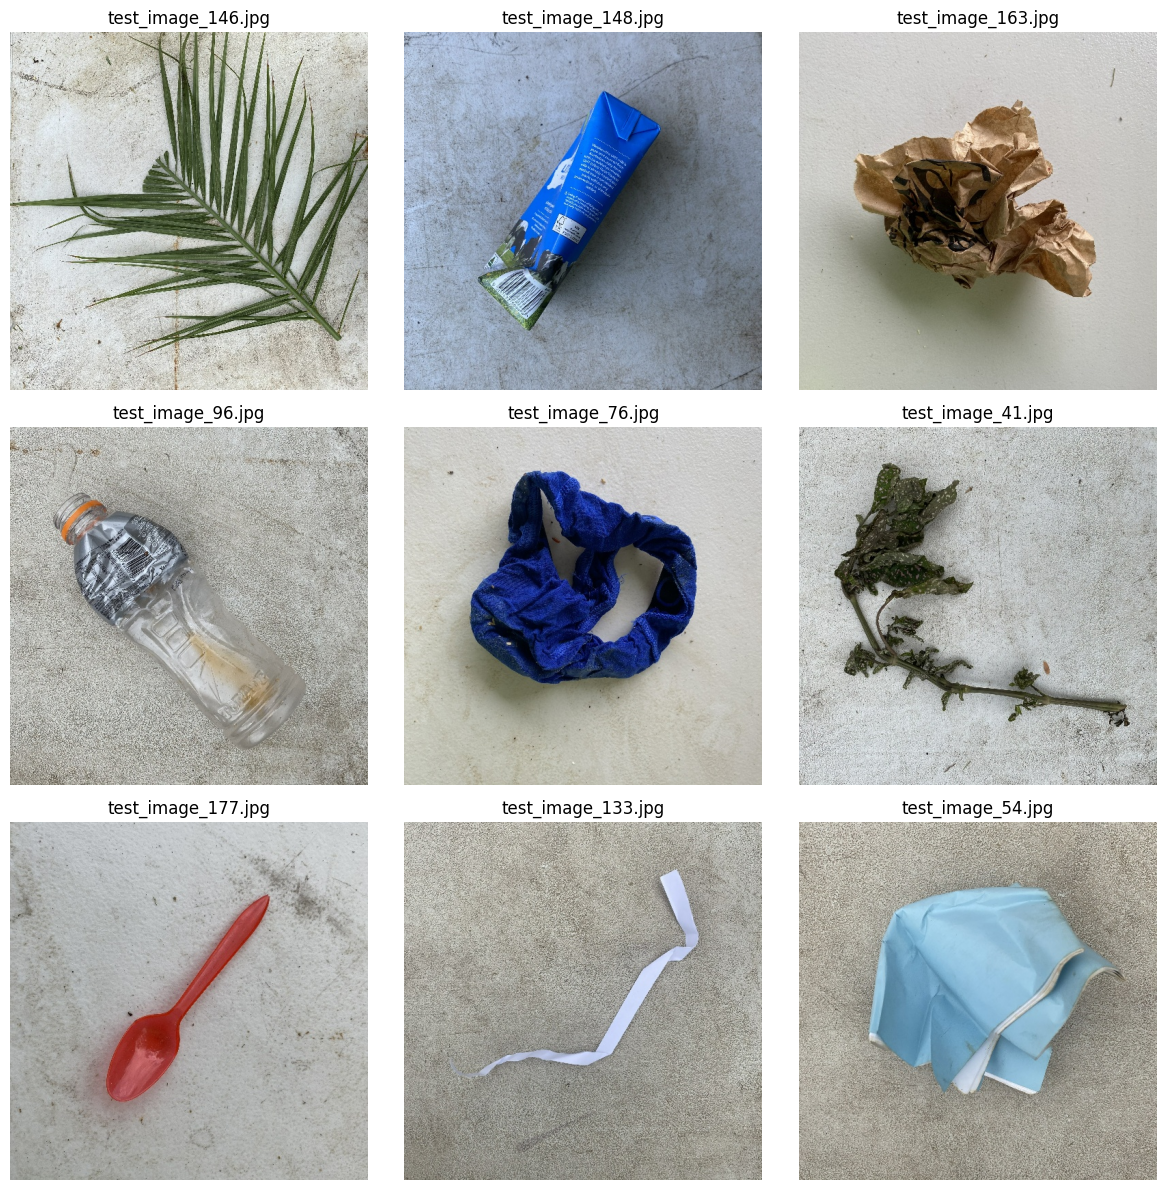

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for ax, img_file in zip(axes.ravel(), selected_test_images):
    img_path = os.path.join(test_image_directory, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(img_file)
    ax.axis('off')  
plt.tight_layout()
plt.show()

In [12]:
def build_model(input_shape=(400,400, 3)):
    model = models.Sequential()
    
    # Convolutional Base
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,kernel_initializer= 'he_uniform'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_initializer= 'he_uniform'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu',kernel_initializer= 'he_uniform'))
    model.add(layers.MaxPooling2D((2, 2)))


    # Dense Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(9, activation='softmax'))  # Binary classification
    
    return model


In [13]:
model = build_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 398, 398, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 199, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 197, 197, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 96, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 294912)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    75,497,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,593,289 (288.37 MB)

 Trainable params: 75,593,289 (288.37 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Training the Model
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=25,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730325689.772638     139 service.cc:145] XLA service 0x783d9c009790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730325689.772701     139 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730325689.772706     139 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/115 ━━━━━━━━━━━━━━━━━━━━ 37:16 20s/step - accuracy: 0.1875 - loss: 0.8890

I0000 00:00:1730325704.125737     139 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 ━━━━━━━━━━━━━━━━━━━━ 78s 515ms/step - accuracy: 0.2541 - loss: 3.0419 - val_accuracy: 0.3582 - val_loss: 0.3064 - learning_rate: 0.0010
Epoch 2/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 37s 305ms/step - accuracy: 0.5345 - loss: 0.2420 - val_accuracy: 0.3823 - val_loss: 0.3193 - learning_rate: 0.0010
Epoch 3/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 36s 303ms/step - accuracy: 0.7451 - loss: 0.1569 - val_accuracy: 0.4294 - val_loss: 0.3332 - learning_rate: 0.0010
Epoch 4/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8687 - loss: 0.1000
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
115/115 ━━━━━━━━━━━━━━━━━━━━ 37s 304ms/step - accuracy: 0.8687 - loss: 0.1000 - val_accuracy: 0.4064 - val_loss: 0.4246 - learning_rate: 0.0010
Epoch 5/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 36s 300ms/step - accuracy: 0.9549 - loss: 0.0448 - val_accuracy: 0.4469 - val_loss: 0.5224 - learning_rate: 5.0000e-04
Epoch 6/25
115/115 ━━━━━━━━━━━━━━━━━━━━ 37s 308ms/step - accuracy: 0.9795 - los

In [17]:
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {val_accuracy:.2f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.3643 - loss: 0.3019
Validation Accuracy: 0.36


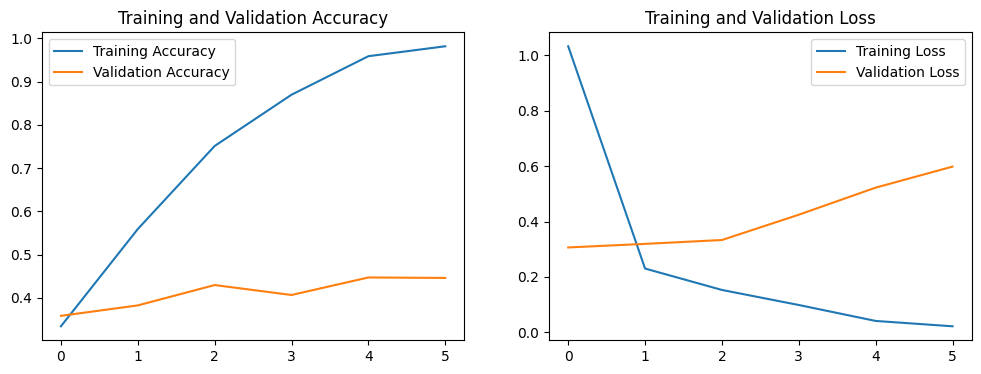

In [18]:
# here as it is visible that there is a very huge difference between training and validation accuracy....
"""" all possible method has been employed, thinking that it is stuck in local minima,
had used even random weight initialization but still its the same...the main reason I
speculate is complicating the whole model ended up facing overfitting.
As I was running short of time, I had to get compromise to this complicated model""""


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [19]:
import pandas as pd
import numpy as np
import re

# Define the mapping from labels to numeric values
label_mapping = {
    'Cardboard': 0,
    'Food Organics': 1,
    'Glass': 2,
    'Metal': 3,
    'Miscellaneous Trash': 4,
    'Paper': 5,
    'Plastic': 6,
    'Textile Trash': 7,
    'Vegetation': 8
}

predictions = model.predict(test_generator)
predicted_class_indices = np.argmax(predictions, axis=1)

filenames = test_generator.filenames  # This retains the original file names in the test directory

image_ids = []
class_labels = []

# Extract the numeric part of the image label
for i, filename in enumerate(filenames):
    image_id = int(re.search(r'_(\d+)\.jpg', filename).group(1))
    image_ids.append(image_id)
    

    predicted_label = predicted_class_indices[i]
    class_labels.append(predicted_label)

submission_df = pd.DataFrame({
    "Image_ID": image_ids,
    "Class_Label": class_labels
})


submission_df.sort_values(by="Image_ID", ascending=True, inplace=True)
submission_df.reset_index(drop=True, inplace=True)

# Save the Submission DataFrame to a CSV File
submission_df.to_csv("submissionC.csv", index=False)

print(submission_df.head())

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 792ms/step
   Image_ID  Class_Label
0         1            8
1         2            8
2         3            5
3         4            2
4         5            3
